In [1]:
%matplotlib inline
import json
import numpy as np
import glob
import matplotlib.pyplot as plt
import brewer2mpl
import math
import pandas as pd
bmap = brewer2mpl.get_map('Set1', 'qualitative', 9)
colors = bmap.mpl_colors

In [28]:
files = [
    '../log/cluster/CMCPos-v0_sarst_final_rnd_2_inf_tanh_True_True_2',
    '../log/results1000/sarst_future_rnd_1_inf_tanh_True_True_1000_2'
]

In [29]:
frames = [] # List of pandas dataframes corresponding to each results file
for file in files:
    # Fetching json files corresponding to one set of parameters
    res_steps = glob.glob(file + '/*/' + 'log_steps/progress.json') 
    for num_run, run in enumerate(res_steps):
        # Discarding runs with broken result files
        try:
            df = pd.read_json(run, lines=True)
        except ValueError:
            print("run "+run+": invalid")
        df['params'] = file.split('/')[-1]
        df['num_run']=num_run
        frames.append(df)
# Creating the complete dataframe with all dat
expe_res_steps = pd.concat(frames, ignore_index=True)
expe_res_steps

,Test reward on initial goal,Test reward on random goal,action_grads,critic_loss,mean_Q_values,mean_action,mean_target_Q_values,mean_target_action,num_run,params,reference_action_grads,training_step
0,-99.124344,-99.426176,-0.406515,NaN,1.259240,NaN,NaN,NaN,0,CMCPos-v0_sarst_final_rnd_2_inf_tanh_True_True_2,NaN,1192
1,-99.827327,-1.200949,-0.051624,NaN,0.148719,NaN,NaN,NaN,0,CMCPos-v0_sarst_final_rnd_2_inf_tanh_True_True_2,NaN,2192
2,-99.618815,-98.515491,-0.040479,NaN,1.842714,NaN,NaN,NaN,0,CMCPos-v0_sarst_final_rnd_2_inf_tanh_True_True_2,NaN,3192
3,-29.598930,-1.968456,0.031401,NaN,1.656162,NaN,NaN,NaN,0,CMCPos-v0_sarst_final_rnd_2_inf_tanh_True_True_2,NaN,4192
4,-66.019227,-98.796453,0.043138,NaN,1.609034,NaN,NaN,NaN,0,CMCPos-v0_sarst_final_rnd_2_inf_tanh_True_True_2,NaN,5192
5,-55.519404,-60.385336,0.174697,NaN,7.164325,NaN,NaN,NaN,0,CMCPos-v0_sarst_final_rnd_2_inf_tanh_True_True_2,NaN,6192
6,-61.274380,99.552971,0.052189,NaN,7.460031,NaN,NaN,NaN,0,CMCPos-v0_sarst_final_rnd_2_inf_tanh_True_True_2,NaN,7192
7,-64.221245,-30.024714,0.093382,NaN,8.736985,NaN,NaN,NaN,0,CMCPos-v0_sarst_final_rnd_2_inf_tanh_True_True_2,NaN,8192
8,-64.180326,47.129630,0.071638,NaN,12.285858,NaN,NaN,NaN,0,CMCPos-v0_sarst_final_rnd_2_inf_tanh_True_True_2,NaN,9192
9,-51.638242,-99.893175,0.140923,NaN,12.316848,NaN,NaN,NaN,0,CMCPos-v0_sarst_final_rnd_2_inf_tanh_True_True_2,NaN,10192


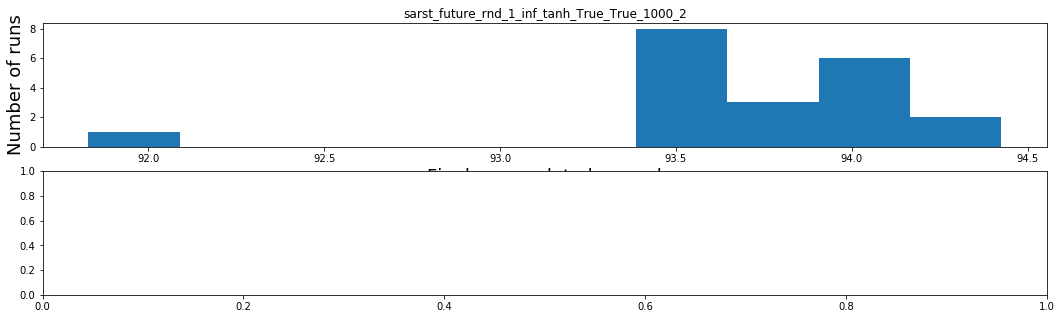

In [25]:
# Only keeping lines corresponding to the evaluation at training step N
N = 199000
res_final = expe_res_steps[expe_res_steps['training_step']==N]

# For each set of parameters, plot the histogram of performances on the initial goal at step N over the different runs
fig, axes = plt.subplots(2,1, figsize=(18,5))
for i,(name, g) in enumerate(res_final.groupby('params')['Test reward on initial goal']):
    axes[i].hist(g)
    axes[i].set_title(name)
    axes[i].set_xlabel('Final accumulated reward', fontsize=18)
    axes[i].set_ylabel('Number of runs', fontsize=18)


(-5000, 200000)

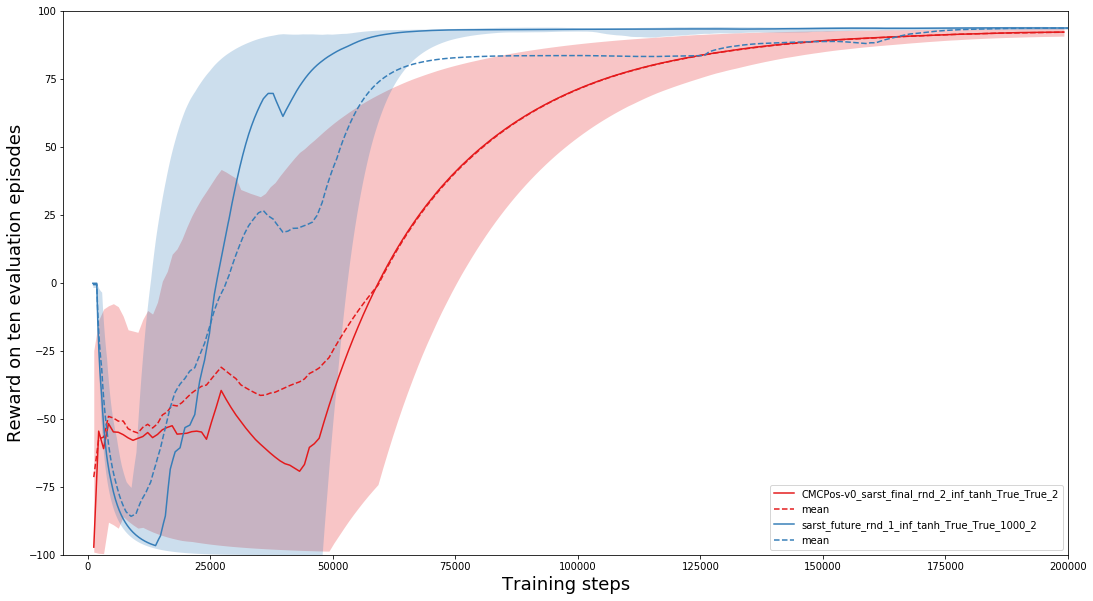

In [30]:
# # Retrieve for each set of parameters the list of runs with final performance over a given threshold. 
# # Can be adapted to filter on different things
# # Store these runs numbers in a dictionary
# dico = {}
# for name, g in expe_res_steps[expe_res_steps['training_step']==199192].groupby('params'):
# #     dico[name] = list(g[g['Test reward on initial goal']>-100]['num_run'].values)
#     dico[name] = list(g['num_run'].values)
#     print(name, dico[name])
    
# # From the dictionary, compute a boolean dataframe, with True at index i if the data at index i of the result dataframe
# # matches the filter. Apply this boolean mask to the results dataframe to retrieve the filtered data
# def in_dico(g):
#     res = g['num_run'] in dico[g['params']]
#     res = (g['num_run'] in [0,1,2,3,4])
#     return res
# mask = expe_res_steps.apply(in_dico, axis=1)
# filtered = expe_res_steps[mask]
filtered = expe_res_steps

# Define the functions for the statistics we want to compute on the dataframe
def quant_inf(x) : return x.quantile(0.1)
def quant_sup(x) : return x.quantile(0.9)
op_dict = {'Test reward on initial goal':[np.mean, np.median, quant_inf,quant_sup]}
columns = ['Test reward on initial goal','training_step','params']

# Apply these functions to the dataframe and store the results in additional columns
stats_eval_init = filtered[columns].groupby(['training_step','params']).agg(op_dict).reset_index()

# Exponentional smoothing of the curve. Increase the ewm parameter for more smoothing.
stats_eval_init_smooth = stats_eval_init[['params','Test reward on initial goal']].groupby('params').apply(lambda x: x.ewm(30).mean())

# Weird bug I had, where the word training caused problems 
stats_eval_init_smooth['trainin_step']=stats_eval_init['training_step']

# Plot the statistics for the results of each set of parameters
fig, ax = plt.subplots(figsize=(18,10))
for i, (name, g) in enumerate(stats_eval_init_smooth.groupby(['params'])):
    params = name.split('_')
#         ax.plot(g['trainin_step'], g['Test reward on initial goal']['mean'], label=name)
    ax.plot(g['trainin_step'], g['Test reward on initial goal']['median'], label=name, color=colors[i])
    ax.plot(g['trainin_step'], g['Test reward on initial goal']['mean'], color=colors[i], linestyle='dashed')
    ax.fill_between(g['trainin_step'], 
                    g['Test reward on initial goal']['quant_inf'], 
                    g['Test reward on initial goal']['quant_sup'], alpha=0.25, linewidth=0, color=colors[i])
ax.legend()
ax.set_xlabel('Training steps', fontsize=18)
ax.set_ylabel('Reward on ten evaluation episodes', fontsize=18)
ax.set_ylim([-100,100])
ax.set_xlim([-5000,200000])


(-5000, 200000)

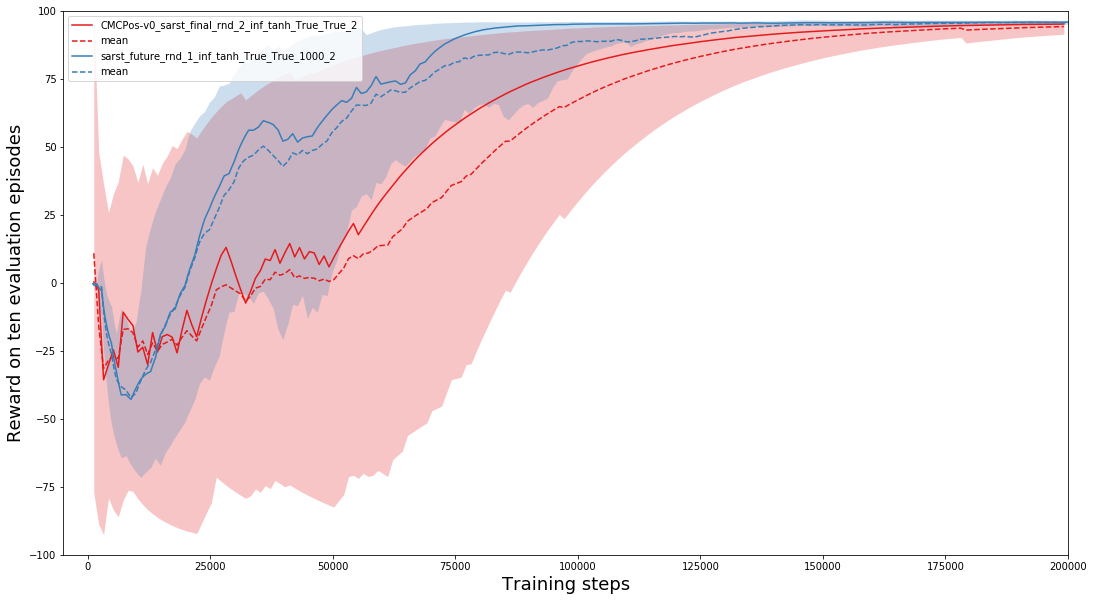

In [31]:
# # Retrieve for each set of parameters the list of runs with final performance over a given threshold. 
# # Can be adapted to filter on different things
# # Store these runs numbers in a dictionary
# dico = {}
# for name, g in expe_res_steps[expe_res_steps['training_step']==199192].groupby('params'):
# #     dico[name] = list(g[g['Test reward on initial goal']>-100]['num_run'].values)
#     dico[name] = list(g['num_run'].values)
#     print(name, dico[name])
    
# # From the dictionary, compute a boolean dataframe, with True at index i if the data at index i of the result dataframe
# # matches the filter. Apply this boolean mask to the results dataframe to retrieve the filtered data
# def in_dico(g):
#     res = g['num_run'] in dico[g['params']]
#     res = (g['num_run'] in [0,1,2,3,4])
#     return res
# mask = expe_res_steps.apply(in_dico, axis=1)
# filtered = expe_res_steps[mask]
filtered = expe_res_steps

# Define the functions for the statistics we want to compute on the dataframe
def quant_inf(x) : return x.quantile(0.1)
def quant_sup(x) : return x.quantile(0.9)
op_dict = {'Test reward on random goal':[np.mean, np.median, quant_inf,quant_sup]}
columns = ['Test reward on random goal','training_step','params']

# Apply these functions to the dataframe and store the results in additional columns
stats_eval_init = filtered[columns].groupby(['training_step','params']).agg(op_dict).reset_index()

# Exponentional smoothing of the curve. Increase the ewm parameter for more smoothing.
stats_eval_init_smooth = stats_eval_init[['params','Test reward on random goal']].groupby('params').apply(lambda x: x.ewm(30).mean())

# Weird bug I had, where the word training caused problems 
stats_eval_init_smooth['trainin_step']=stats_eval_init['training_step']

# Plot the statistics for the results of each set of parameters
fig, ax = plt.subplots(figsize=(18,10))
for i, (name, g) in enumerate(stats_eval_init_smooth.groupby(['params'])):
    params = name.split('_')
#         ax.plot(g['trainin_step'], g['Test reward on initial goal']['mean'], label=name)
    ax.plot(g['trainin_step'], g['Test reward on random goal']['median'], label=name, color=colors[i])
    ax.plot(g['trainin_step'], g['Test reward on random goal']['mean'], color=colors[i], linestyle='dashed')
    ax.fill_between(g['trainin_step'], 
                    g['Test reward on random goal']['quant_inf'], 
                    g['Test reward on random goal']['quant_sup'], alpha=0.25, linewidth=0, color=colors[i])
ax.legend()
ax.set_xlabel('Training steps', fontsize=18)
ax.set_ylabel('Reward on ten evaluation episodes', fontsize=18)
ax.set_ylim([-100,100])
ax.set_xlim([-5000,200000])

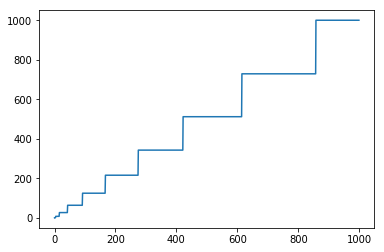

In [25]:
x = range(1000)
y = [int(round(a ** (1/3)) ** 3) for a in x]
plt.plot(x,y)

<a list of 34 Text yticklabel objects>


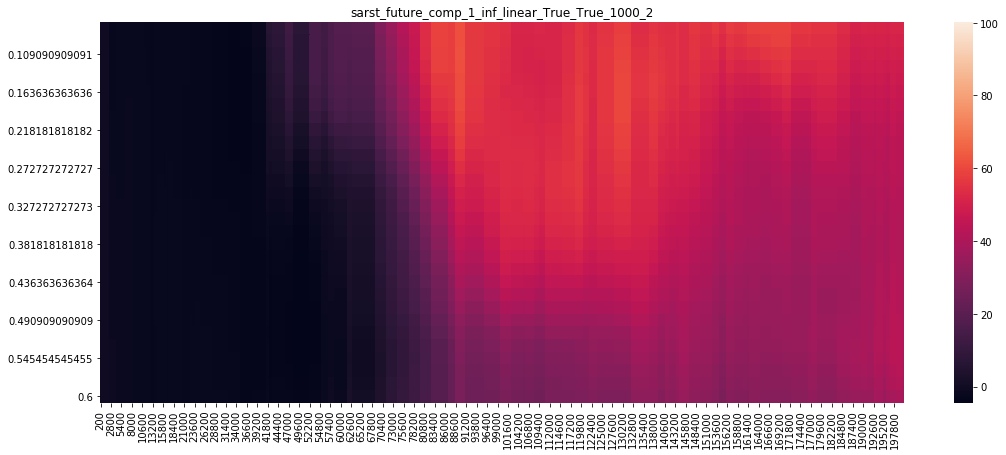

In [51]:
import seaborn as sns
fig, axes = plt.subplots(len(PARAMS), figsize=(18,7))
expe_res_steps_0 = expe_res_steps[(expe_res_steps['num_run']==0)]
# expe_res_steps_0 = expe_res_steps[(expe_res_steps['num_run']==0) & (expe_res_steps['training_step']<=70000)]
for i, (name, g) in enumerate(expe_res_steps_0.groupby('params')):
    q_vals = g['q_values'].apply(pd.Series)
    heatmap = q_vals.T
    heatmap.columns = range(200, 200001,200)
#     heatmap.columns = range(200, 70001,200)
    sns.heatmap(heatmap, ax=axes)
    axes.set_title(name)
    print(axes.get_yticklabels())
    axes.set_ylim([100,70])
    axes.set_yticklabels([list(np.linspace(-1.2, 0.6, 100))[int(label.get_text())] for label in axes.get_yticklabels()])

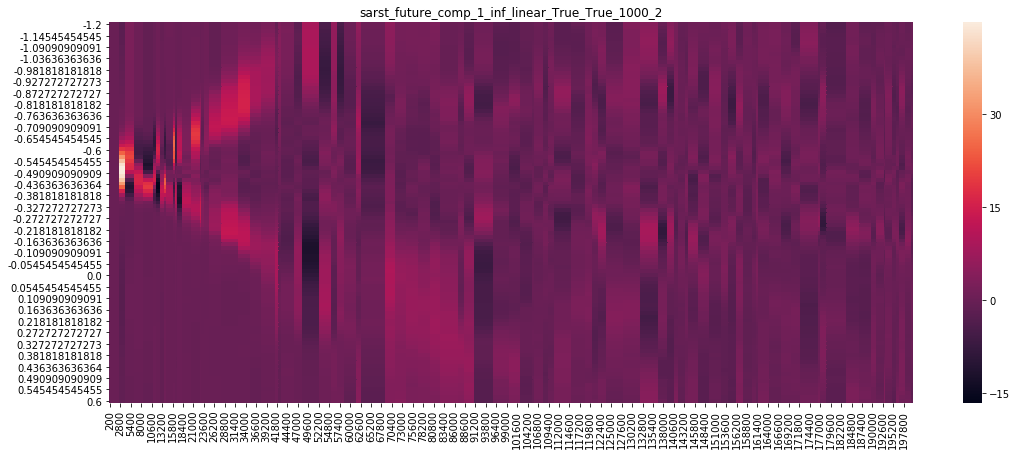

In [42]:
import seaborn as sns
fig, axes = plt.subplots(len(PARAMS), figsize=(18,7))
expe_res_steps_0 = expe_res_steps[(expe_res_steps['num_run']==0)]
# expe_res_steps_0 = expe_res_steps[(expe_res_steps['num_run']==0) & (expe_res_steps['training_step']<=70000)]
for i, (name, g) in enumerate(expe_res_steps_0.groupby('params')):
    q_vals = g['d_q_values'].apply(pd.Series)
    heatmap = q_vals.T
    heatmap.columns = range(200, 200001,200)
#     heatmap.columns = range(200, 70001,200)
    sns.heatmap(heatmap, ax=axes)
    axes.set_title(name)
    axes.set_yticklabels([list(np.linspace(-1.2, 0.6, 100))[int(label.get_text())] for label in axes.get_yticklabels()])
#     axes.set_xlim([0,70000])

In [43]:
frames = []
for PARAM in PARAMS:
    param_vals = PARAM.split('_')
    res_episodes = glob.glob(LOGDIR + PARAM + '/*/' + 'log_episodes/progress.json')
    for num_run, run in enumerate(res_episodes):
        try:
            df = pd.read_json(run, lines=True)
        except ValueError:
            print("run "+run+": invalid")
        df['params'] = PARAM
        df['num_run']=num_run
        frames.append(df)
expe_res_episodes = pd.concat(frames, ignore_index=True)
expe_res_episodes

,Duration,Episode,Episode steps,Final_state,Goal,Goal reached,Start,Train reward,Train step,params,num_run
0,0.215156,1,35,-0.207075,-0.218182,1,-0.481433,97.295769,35,sarst_future_comp_1_inf_linear_True_True_1000_2,0
1,0.514785,2,101,-0.123212,-0.145455,2,-0.456615,92.479165,136,sarst_future_comp_1_inf_linear_True_True_1000_2,0
2,0.544616,3,17,-0.338596,-0.345455,3,-0.597645,98.300000,153,sarst_future_comp_1_inf_linear_True_True_1000_2,0
3,10.886660,4,152,-1.057473,-1.036364,4,-0.443859,87.743435,305,sarst_future_comp_1_inf_linear_True_True_1000_2,0
4,11.879921,5,13,-0.633381,-0.618182,5,-0.492799,98.700000,318,sarst_future_comp_1_inf_linear_True_True_1000_2,0
5,22.346054,6,157,-0.307330,-0.345455,6,-0.443837,86.858679,475,sarst_future_comp_1_inf_linear_True_True_1000_2,0
6,116.192528,7,1000,-0.578187,0.545455,6,-0.502574,-96.510592,1475,sarst_future_comp_1_inf_linear_True_True_1000_2,0
7,212.826460,8,1000,-0.399769,-0.672727,6,-0.480715,-100.000000,2475,sarst_future_comp_1_inf_linear_True_True_1000_2,0
8,215.112139,9,40,0.037898,0.036364,7,-0.583453,96.000000,2515,sarst_future_comp_1_inf_linear_True_True_1000_2,0
9,217.643441,10,40,0.055156,0.054545,8,-0.594253,96.000000,2555,sarst_future_comp_1_inf_linear_True_True_1000_2,0


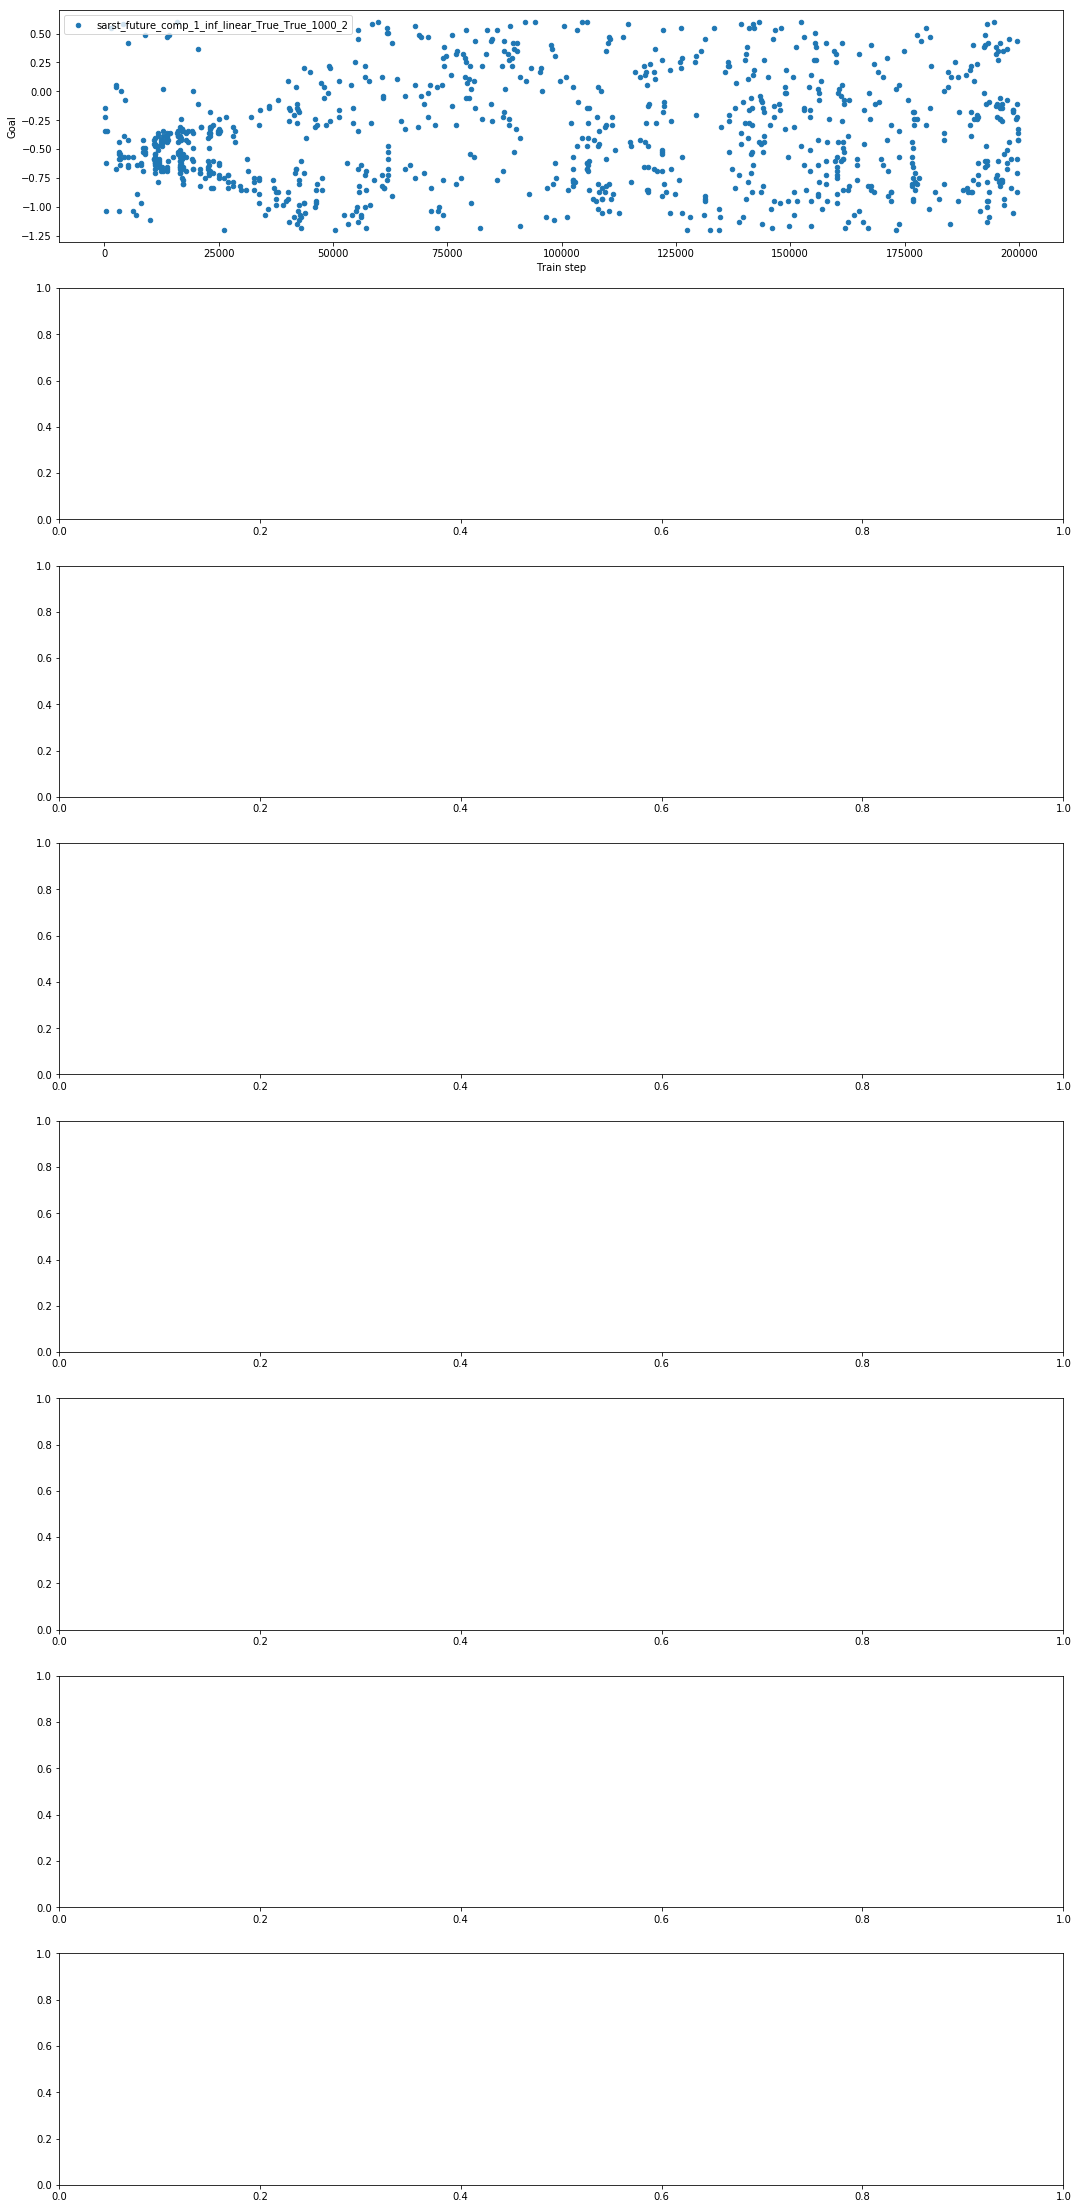

In [44]:
expe_res_ep_plot = expe_res_episodes[expe_res_episodes['num_run']==0]
fig, axes = plt.subplots(8, figsize=(18,40))
for i, (name, g) in enumerate(expe_res_ep_plot.groupby('params')):
    g.plot(x='Train step', y='Goal', label=name, ax=axes[i], kind='scatter')